In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from scipy.linalg import svd
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [2]:
#reading images
path = 'data/cat_imgs/'
imgs = [Image.open(path + file).convert('L') for file in os.listdir(path)]
imgs = [np.array(img) / 255 for img in imgs]
#saving images grayscale
for i in range(len(imgs)):
    plt.imsave('figs/comp_cats_img/cat{}.jpg'.format(i+1), imgs[i], cmap='gray')

<Figure size 432x288 with 0 Axes>

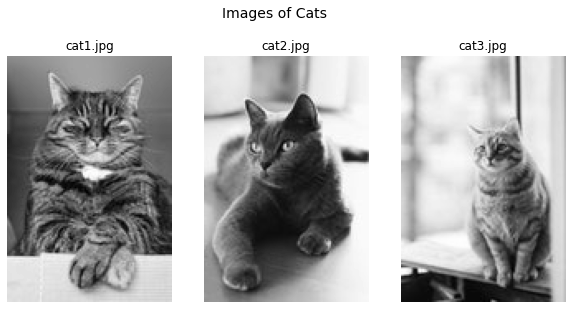

In [3]:
def plot_images(imgs, title):
    ncols=len(imgs)
    plt.figure()
    fig, axs = plt.subplots(1, ncols, figsize=(10,5))
    fig.suptitle("Images of Cats ", fontsize=14)

    for i in range(ncols):
        axs[i].set_title('cat{}.jpg'.format(i+1))
        axs[i].imshow(imgs[i], cmap='gray')
        axs[i].axis('off')
    plt.savefig('figs/{}.png'.format(title), dpi=300)

plot_images(imgs, 'cats')

In [4]:
def PCA(X):

    #standardizing data
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    m, n = X.shape

    #covariance matrix
    cov_matrix = np.dot(X_std, np.transpose(X_std)) / (n - 1)

    #applying Singular Value Decomposition - SVD
    U, S, V = svd(cov_matrix)

    #explained variance
    explained_var = [eig_component / sum(S) for eig_component in S]
    cumulative_explained_var = np.cumsum(explained_var)
    
    return U, S, V, explained_var, cumulative_explained_var

<Figure size 432x288 with 0 Axes>

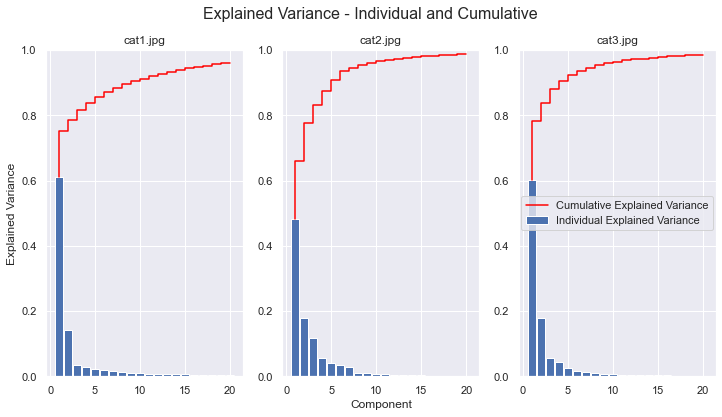

In [5]:
#plotting explained variance for each image

def plot_explained_variance(X, title, n_comp = 20):

    sns.set()
    ncols=len(imgs)
    plt.figure()
    fig, axs = plt.subplots(1, ncols, figsize=(12,6))
    fig.suptitle('Explained Variance - Individual and Cumulative', fontsize=16)

    for i in range(ncols):
        
        axs[i].set_title('cat{}.jpg'.format(i+1))

        U, S, V, explained_var, cum_expained_var = PCA(X[i])
        
        if(i==0):
            axs[i].set_ylabel('Explained Variance')
        if(i==1):
            axs[i].set_xlabel('Component')
        
        axs[i].set_ylim([0, 1])
        #barplot attributes
        x = range(1, len(explained_var[:n_comp])+1)
        height = explained_var[:n_comp]
        width = 0.9
        
        axs[i].bar(x, height, alpha=1, width=width, label='Individual Explained Variance')
        axs[i].step(x, cum_expained_var[:n_comp], color='red', label='Cumulative Explained Variance')
    plt.legend(loc='center')    
    plt.savefig('figs/{}.png'.format(title), dpi=300)
    

plot_explained_variance(imgs, 'explained_variance')

In [6]:
#performing compression using SVD and truncation of the matrix V
def image_compression(X, n_comp):
    compressed_imgs = []
    for x in X:
        U, S, V, explained_var, cum_expained_var = PCA(x)
        VV = V[:150][:n_comp] #truncate V (mxk, where k<m)
        YY = np.dot(VV, x) #YY (kxn)
        XX = np.dot(np.transpose(VV), YY) #compressed image X (mxn, same size as the original)
        compressed_imgs.append(XX)
    return compressed_imgs

In [7]:
#plotting compressed images
def plot_compressed_images(imgs, title, subtitle):
    ncols=len(imgs)
    plt.figure()
    fig, axs = plt.subplots(1, ncols, figsize=(10,5))
    fig.suptitle(subtitle, fontsize=14)

    for i in range(ncols):
        axs[i].set_title('cat{}.jpg'.format(i+1))
        axs[i].imshow(imgs[i], cmap='gray')
        axs[i].axis('off')
    plt.savefig('figs/comp_cats_img/{}.jpg'.format(title), dpi=300)

<Figure size 432x288 with 0 Axes>

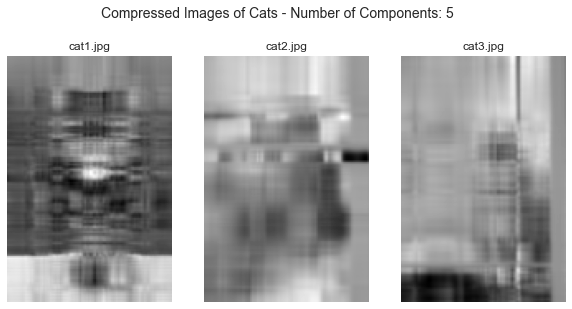

<Figure size 432x288 with 0 Axes>

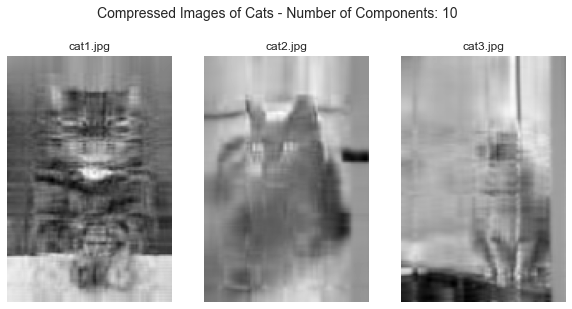

<Figure size 432x288 with 0 Axes>

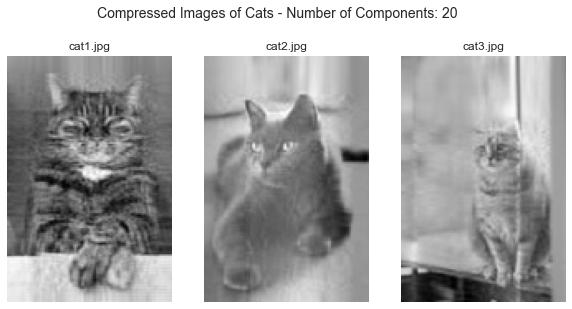

<Figure size 432x288 with 0 Axes>

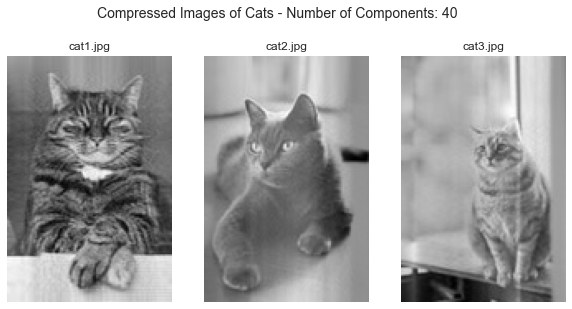

<Figure size 432x288 with 0 Axes>

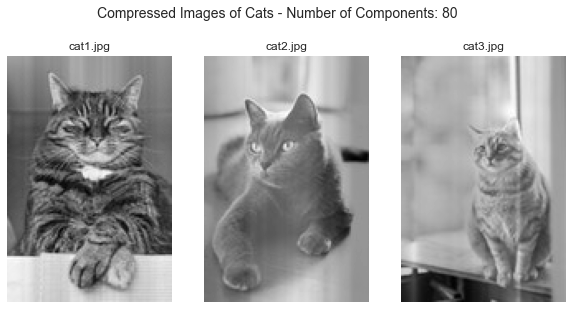

In [8]:
#performing comparisons and saving new compressed images
n_comps = [5, 10, 20, 40, 80] # number of components used to represent the data

for n_comp in n_comps:
    compressed_imgs = image_compression(imgs, n_comp)
    subtitle = 'Compressed Images of Cats - Number of Components: {}'.format(n_comp)
    plot_compressed_images(compressed_imgs, 'comp_cats_PCA_{}'.format(n_comp), subtitle)
    
    #saving individual compressed images
    j = 1
    for compressed_img in compressed_imgs:
        plt.imsave('figs/comp_cats_img/cat{}_PCA_{}.jpg'.format(j, n_comp), compressed_img, cmap='gray')
        j+=1

In [9]:
#imgs sizes in Bytes
path = 'figs/comp_cats_img/'
normal_sizes = pd.DataFrame(
    [{'file': file,
      'size': os.path.getsize(path+file)} 
       for file in os.listdir(path) if 'PCA' not in file and 'jpg' in file]
)

compressed_sizes = pd.DataFrame(
    [{'file': file,
      'size': os.path.getsize(path+file)} 
       for file in os.listdir(path) if 'jpg' in file and 'PCA' in file and 'comp' not in file]
)

In [10]:
normal_sizes

,file,size
0,cat1.jpg,4428
1,cat2.jpg,3334
2,cat3.jpg,3523


In [11]:
compressed_sizes

,file,size
0,cat1_PCA_10.jpg,3277
1,cat1_PCA_20.jpg,3790
2,cat1_PCA_40.jpg,4051
3,cat1_PCA_5.jpg,2903
4,cat1_PCA_80.jpg,4207
5,cat2_PCA_10.jpg,2427
6,cat2_PCA_20.jpg,2687
7,cat2_PCA_40.jpg,2717
8,cat2_PCA_5.jpg,2214
9,cat2_PCA_80.jpg,2755
